In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys 
sys.path.append(".")
# sys.path.append("..")
import shutil
import re
import glob
import torch
import numpy as np
from typing import List, Dict, Optional
from PIL import Image

from divide_and_bind.pipeline_divide_and_bind import DivideAndBindPipeline, get_indices_to_alter
from divide_and_bind.config import RunConfig
from utils.ptp_utils import AttentionStore
from utils import ptp_utils
from utils.annotation_sd import aggregate_attention, show_image_relevance, view_images
from utils.test_utils import run_and_display, default_param

# 0. Load Model Weights (may take minutes)

In [3]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# Path to Stable Diffusion 1.5
pretrained_dir = './pretrained/stable-diffusion-v1-5'
stable = DivideAndBindPipeline.from_pretrained(pretrained_dir).to(device)
tokenizer = stable.tokenizer

In [4]:
output_dir = './test_outputs'
os.makedirs(output_dir, exist_ok=True)

# 1. Compare different losses

  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. 3-dog has a max attention of 0.028093084692955017
	 Try 2. 3-dog has a max attention of 0.029710272327065468
	 Try 3. 3-dog has a max attention of 0.0315655954182148
	 Try 4. 3-dog has a max attention of 0.033711597323417664
	 Try 5. 3-dog has a max attention of 0.03632747754454613
	 Try 6. 3-dog has a max attention of 0.039622221142053604
	 Try 7. 3-dog has a max attention of 0.044088102877140045
	 Try 8. 3-dog has a max attention of 0.05086400732398033
	 Try 9. 3-dog has a max attention of 0.0636100023984909
	 Try 10. 3-dog has a max attention of 0.09709101170301437
	 Try 11. 3-dog has a max attention of 0.2104780077934265
	 Try 12. 3-dog has a max attention of 0.3516104519367218
	 Finished with loss of: -0.0764697715640068
Iteration 0 | Loss: -0.0765
Iteration 1 | Loss: -0.1115
Iteration 2 | Loss: -0.1132
Iteration 3 | Loss: -0.1344
Iteration 4 | Loss: -0.1437
Iteration 5 | Loss: -0.1503
Iteration 6 | Loss: -0.1461
Iteration 7 | Loss: -0.1520
Iteration 8 | Loss: -0.1302
Ite

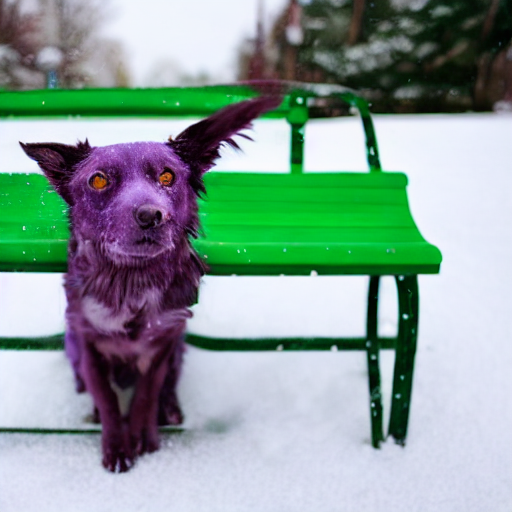

  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. 3-dog has a max attention of 0.0582721121609211
	 Try 2. 3-dog has a max attention of 0.06972700357437134
	 Try 3. 3-dog has a max attention of 0.08346181362867355
	 Try 4. 3-dog has a max attention of 0.09942594170570374
	 Try 5. 3-dog has a max attention of 0.11762513965368271
	 Try 6. 3-dog has a max attention of 0.13820073008537292
	 Try 7. 3-dog has a max attention of 0.16166618466377258
	 Try 8. 3-dog has a max attention of 0.1889123022556305
	 Try 9. 3-dog has a max attention of 0.22128334641456604
	 Try 10. 3-dog has a max attention of 0.2602534890174866
	 Try 11. 3-dog has a max attention of 0.3129478096961975
	 Try 12. 3-dog has a max attention of 0.37181445956230164
	 Try 13. 3-dog has a max attention of 0.4325781762599945
	 Try 14. 3-dog has a max attention of 0.4926765561103821
	 Finished with loss of: -0.07769142091274261
Iteration 0 | Loss: -0.0777
Iteration 1 | Loss: -0.1135
Iteration 2 | Loss: -0.1119
Iteration 3 | Loss: -0.1399
Iteration 4 | Loss: -0.1578
Ite

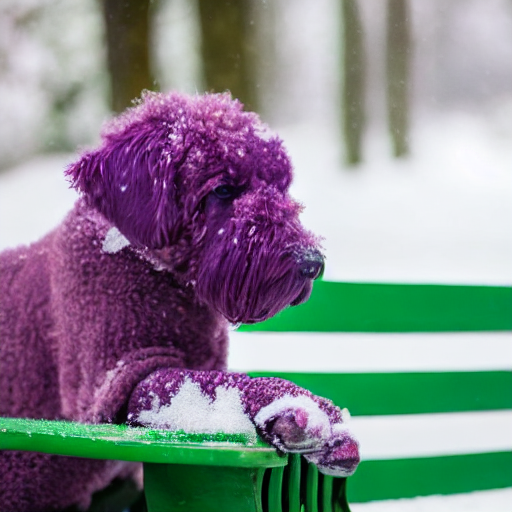

  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. 3-dog has a max attention of 0.027766667306423187
	 Try 2. 3-dog has a max attention of 0.02823280543088913
	 Try 3. 3-dog has a max attention of 0.028721638023853302
	 Try 4. 3-dog has a max attention of 0.029233163222670555
	 Try 5. 3-dog has a max attention of 0.029770947992801666
	 Try 6. 3-dog has a max attention of 0.030353255569934845
	 Try 7. 3-dog has a max attention of 0.03099425695836544
	 Try 8. 3-dog has a max attention of 0.03168899193406105
	 Try 9. 3-dog has a max attention of 0.03243942931294441
	 Try 10. 3-dog has a max attention of 0.033230479806661606
	 Try 11. 3-dog has a max attention of 0.03407907858490944
	 Try 12. 3-dog has a max attention of 0.034977588802576065
	 Try 13. 3-dog has a max attention of 0.035930849611759186
	 Try 14. 3-dog has a max attention of 0.03697632625699043
	 Try 15. 3-dog has a max attention of 0.0380951389670372
	 Try 16. 3-dog has a max attention of 0.03931674361228943
	 Try 17. 3-dog has a max attention of 0.04071671888232231

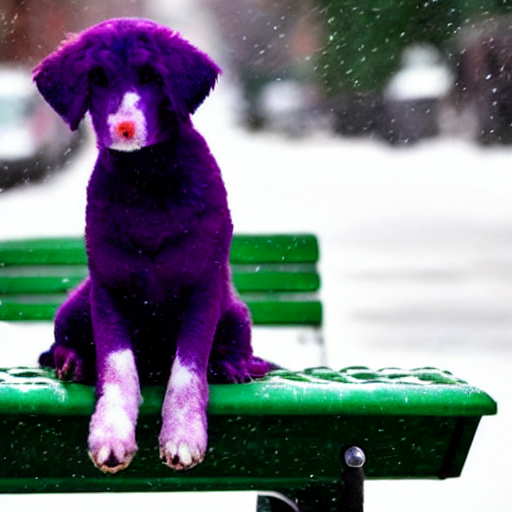

In [5]:
#prompt = 'a dog and a turtle on the street,snowy driving scene'
prompt = 'a purple dog and a green bench on the street,snowy driving scene'
token_indices = [3,7] #[2,5] # 
color_index_list = [2,6] # None if there are no attributes
seeds = [2702, 4749, 3673]


#################
# Loss related  #
#################
do_optimization = True #False -> switch to normal SD

loss_mode_avail_list  = ['max', 'tv', 'tv_bind']
loss_mode = 'max' # Attend and Excite
#loss_mode = 'tv'
loss_mode = 'tv_bind'
assert loss_mode in loss_mode_avail_list

###################################
# Attention visualizaton related  #
###################################
save_attn_vis = False #  change here if do not want to save attention vis!  
pickle_store_timestep_list=None #[25,50] # if storing attention maps in pickle
save_attn_everystep = False
keep_timestep_list = [5,25,40] # None if do not need attention visualization
store_every_step = False

########################################
# Optimization related hyperparameters #
########################################  
max_iter_to_alter = 25 
display_output = True
loss_parm_dict = default_param(loss_mode)


# Avoid memory explosion
try:
    del controller
except:
    pass

for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    img_name = prompt.replace(" ", "_")[:50]
    img_name += f'_seed{seed}'
    if do_optimization:
        img_name += f'_opt_{loss_mode}'
    output_dir_name =os.path.join(output_dir, img_name)
    img_name += '.png'
    
    from utils.ptp_utils import AttentionStore
    
    controller = AttentionStore(
        store_every_step=store_every_step,
        output_dir=output_dir_name,
        pickle_store_timestep_list=pickle_store_timestep_list,
        keep_timestep_list=keep_timestep_list,
        save_attn_vis=save_attn_vis, 
    )
    
    run_standard_sd = False if do_optimization else True
    image = run_and_display(
        model=stable,
        prompts=prompts, 
        controller=controller,
        indices_to_alter=token_indices,
        generator=g, 
        run_standard_sd=run_standard_sd,
        save_attn_everystep=save_attn_everystep,
        display_output=display_output,
        thresholds=loss_parm_dict['thresholds'], 
        max_iter_to_alter=max_iter_to_alter,
        loss_mode=loss_mode,
        max_refinement_steps_init_step=loss_parm_dict['max_refinement_steps_init_step'],
        color_index_list = color_index_list,
        threshold_indicator=loss_parm_dict['threshold_indicator'],
    )
    image_name = os.path.join(output_dir,img_name)
    image.save(image_name)

# 2. Attention Visualization

In [6]:
load_attn_dict = controller.get_attn_dict() 
print(f'Available timesteps for visualization: ', keep_timestep_list)

Available timesteps for visualization:  [5, 25, 40]


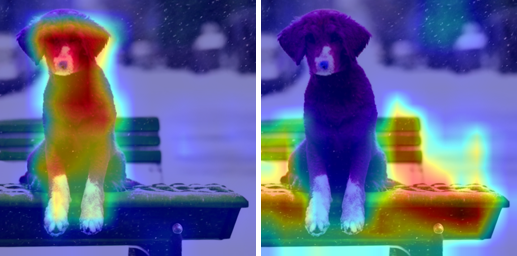

In [7]:
t = 5
assert t in keep_timestep_list

attn_list = [
    load_attn_dict[t]['down_cross'][4][8:], load_attn_dict[t]['down_cross'][5][8:],
    load_attn_dict[t]['mid_cross'][0][8:], load_attn_dict[t]['up_cross'][0][8:],
    load_attn_dict[t]['up_cross'][1][8:], load_attn_dict[t]['up_cross'][2][8:],
]

res_required = 16
agg_attn = aggregate_attention(attn_list,res_required)
vis_list = []
id_list = token_indices # spcify the token indices here
img_pil = image
res_required_vis = 256

for selected_id in id_list:
    image_relevance = agg_attn[:,:,:,selected_id].mean(0)
    vis = show_image_relevance(image_relevance, img_pil, relevnace_res=res_required_vis)
    vis = vis.astype(np.uint8)
    vis_list.append(vis)
attn_pil = view_images(vis_list)

In [8]:
# ca_img_name = image_name[:-4] + f'_ca_{t}_SD.png'
# attn_pil.save(ca_img_name)